In [1]:
import os
import copy
import numpy as np
import numpy.ma as ma
import wandb
import rioxarray
import xarray as xr
import rasterio
import time
from functools import wraps
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
from osgeo import gdal, ogr
import pandas as pd
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS
from src.data_loading.landcover_plot_utils import classes_to_rgb
SAT_DIR = "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data"

## Look at classes in original ESA CCI data

In [2]:
input_filepaths = [GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson" for year in range(1992, 2016)]

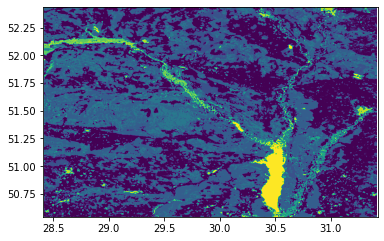

<AxesSubplot:>

In [3]:
from rasterio.plot import show
chernobyl_2015_wgs84 = rasterio.open(input_filepaths[-1])
show(chernobyl_2015_wgs84)

In [4]:
roi_ds = gdal.Open('/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/esa_cci_rois/esa_cci_2015_chernobyl.geojson', gdal.GA_ReadOnly)    

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 1362 pixels
Class 10 contains 274659 pixels
Class 11 contains 43365 pixels
Class 30 contains 21756 pixels
Class 40 contains 3636 pixels
Class 60 contains 60509 pixels
Class 61 contains 240 pixels
Class 70 contains 191751 pixels
Class 80 contains 2 pixels
Class 90 contains 57439 pixels
Class 100 contains 30511 pixels
Class 110 contains 84 pixels
Class 130 contains 14072 pixels
Class 150 contains 159 pixels
Class 160 contains 9329 pixels
Class 180 contains 1827 pixels
Class 190 contains 10869 pixels
Class 200 contains 38 pixels
Class 201 contains 3 pixels
Class 210 contains 17955 pixels


In [5]:
new_classes = ['Agriculture','Deciduous forest', 'Evergreen forest', 'Swamp forest', 'Grassland',
              'Shrubland', 'Urban', 'Sparse vegetation', 'Water', 'Wetland', 'No data']

In [6]:
data=[]
for c in classes:
    data.append((roi == c).sum())
classes_df = pd.DataFrame(data, index = classes, columns = ['pixel_count'])   
classes_df   


,pixel_count
0,1362
10,274659
11,43365
30,21756
40,3636
60,60509
61,240
70,191751
80,2
90,57439


In [7]:
agri = classes_df.loc[[10,11,30,40]].sum()
dec_for = classes_df.loc[[60,61,80,90,100]].sum()
evg_for = classes_df.loc[[70]].sum()
sw_for = classes_df.loc[[160]].sum()
grassland = classes_df.loc[[110,130]].sum()
shrubland = 0
urban = classes_df.loc[[190]].sum()
sparse_veg = classes_df.loc[[150,200,201]].sum()
water = classes_df.loc[[210]].sum()
wetland = classes_df.loc[[180]].sum()
n_a = classes_df.loc[[0]].sum()

In [8]:
new_class_pixels = [agri['pixel_count'], dec_for['pixel_count'], evg_for['pixel_count'], 
                    sw_for['pixel_count'], grassland['pixel_count'], shrubland, 
                    urban['pixel_count'], sparse_veg['pixel_count'], water['pixel_count'],
                    wetland['pixel_count'], n_a['pixel_count']]

new_classes_df = pd.DataFrame(new_class_pixels, index = new_classes, columns =['pixel_count'])
new_classes_df

,pixel_count
Agriculture,343416
Deciduous forest,148701
Evergreen forest,191751
Swamp forest,9329
Grassland,14156
Shrubland,0
Urban,10869
Sparse vegetation,200
Water,17955
Wetland,1827


From this 2015 example you can see that there is some class imbalance in teh training data. The above is the pixel count from the original ESA CCI image with the list of proposed new classes. The 'Shrubland' class contains no training data at all and the 'sparse vegetation' class also has a low count. The 'Urban class has a lower count than other classes but it doesn't appear low enough for the classifier to miss it out completely.

To do: work out method of combining correct classes in training arrays and passing through the classifier

### Look at 1992 where urban area disappears

In [9]:
roi_ds_92 = gdal.Open('/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/esa_cci_rois/esa_cci_1992_chernobyl.geojson', gdal.GA_ReadOnly)    

roi_92 = roi_ds_92.GetRasterBand(1).ReadAsArray()

classes_92 = np.unique(roi_92)

In [10]:
data_92 = []
for c in classes_92:
    data_92.append((roi_92 == c).sum())
classes_df_92 = pd.DataFrame(data_92, index = classes_92, columns = ['pixel_count'])   
classes_df_92  

,pixel_count
0,1362
10,271374
11,42674
30,25319
40,37681
60,49043
61,205
70,191598
80,2
90,52761


In [11]:
agri_92 = classes_df_92.loc[[10,11,30,40]].sum()
dec_for_92 = classes_df_92.loc[[60,61,80,90,100]].sum()
evg_for_92 = classes_df_92.loc[[70]].sum()
sw_for_92 = classes_df_92.loc[[160]].sum()
grassland_92 = classes_df_92.loc[[110,130]].sum()
shrubland_92 = 0
urban_92 = classes_df_92.loc[[190]].sum()
sparse_veg_92 = classes_df_92.loc[[150,200,201]].sum()
water_92 = classes_df_92.loc[[210]].sum()
wetland_92 = classes_df_92.loc[[180]].sum()
n_a_92 = classes_df_92.loc[[0]].sum()

In [12]:
new_class_pixels_92 = [agri_92['pixel_count'], dec_for_92['pixel_count'], evg_for_92['pixel_count'], 
                    sw_for_92['pixel_count'], grassland_92['pixel_count'], shrubland_92, 
                    urban_92['pixel_count'], sparse_veg_92['pixel_count'], water_92['pixel_count'],
                    wetland_92['pixel_count'], n_a_92['pixel_count']]

new_classes_df_92 = pd.DataFrame(new_class_pixels_92, index = new_classes, columns =['pixel_count'])
new_classes_df_92

,pixel_count
Agriculture,377048
Deciduous forest,123674
Evergreen forest,191598
Swamp forest,8236
Grassland,13489
Shrubland,0
Urban,4292
Sparse vegetation,236
Water,17947
Wetland,1684


There are some urban pixels in 1992 but far fewer than in 2015. Aside from that large change the general balance of classes appears consistent. May need to remove shrubland class since it appears to be irrelevant for our area.

## Look at mapping to landsat grid

In [16]:
from src.models.xgb import return_normalized_array, timeit

### Let's look at 2015

In [17]:
return_normalized_array(file_name=os.path.join(SAT_DIR, '2015/L8_chern_2015_AMJ.tif'),
                       filter_together=True,
                       high_limit=3e3,
                       low_limit=0,
                       high_filter=True,
                       low_filter=True,
                       common_norm=True)

'return_normalized_array'  27.70007 s



array([[[0.06966667, 0.12766667, 0.07366667],
        [0.06966667, 0.12766667, 0.07366667],
        [0.07366667, 0.13033333, 0.07533333],
        ...,
        [0.088     , 0.14033333, 0.07866667],
        [0.08733333, 0.137     , 0.07766667],
        [0.08733333, 0.137     , 0.07766667]],

       [[0.06533333, 0.1295    , 0.07333333],
        [0.06533333, 0.1295    , 0.07333333],
        [0.07083333, 0.132     , 0.07516667],
        ...,
        [0.08833333, 0.14633333, 0.07933333],
        [0.091     , 0.14766667, 0.08033333],
        [0.091     , 0.14766667, 0.08033333]],

       [[0.06316667, 0.125     , 0.07116667],
        [0.06316667, 0.125     , 0.07116667],
        [0.06766667, 0.124     , 0.07133333],
        ...,
        [0.097     , 0.173     , 0.091     ],
        [0.09933333, 0.17266667, 0.08933333],
        [0.09933333, 0.17266667, 0.08933333]],

       ...,

       [[0.207     , 0.24133333, 0.267     ],
        [0.207     , 0.24133333, 0.267     ],
        [0.2105    , 0

In [27]:
@timeit
def _return_x_y_da(
    take_esa_coords=False,
    use_mfd=True,
):
    """
    Load the preprocced Landsat and ESA cci data on the same format of xarray.dataaray grids.
    # TODO: Find a way to memoise this so that it doesn't need to be repeated every time.
    :param take_esa_coords: bool, if true use the lower resolution grid from esa ccis
    current time taken to run: 'return_x_y_da'  431.59196 s
    TODO: Currently when take_esa_coords=False, the process runs out of memory.
    """
    mn_l =  ["JFM", "AMJ", "JAS", "OND"]

    @timeit
    def return_y_da():
        input_filepaths = [
                GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_2015_chernobyl.geojson"
                #for year in range(1992, 2016)
            ]
        da_list = []
        for i in range(len(input_filepaths)):
            file_name = input_filepaths[i]
            da_list.append(xr.open_rasterio(file_name).isel(band=0))
        return xr.concat(da_list, "yr").assign_coords(yr=("yr", 2015)) #list(range(1992, 2016))))

    @timeit
    def return_part_x_da(ty_v="chern", mn_v="JAS"):
        directory = os.path.join(SAT_DIR, "nc_"+ ty_v)
        return xr.open_dataset(os.path.join(directory, ty_v + "_" + mn_v + ".nc")).norm_refl
    
    def return_x_name_list(ty_v="chern"):
        directory = os.path.join(SAT_DIR, "nc_"+ ty_v)
        return [os.path.join(directory, ty_v + "_" + mn_v + ".nc") for mn_v in mn_l],
    
    @timeit
    def reindex_da(mould_da, putty_da):
        putty_da.reindex(
                x=mould_da.coords["x"].values,
                y=mould_da.coords["y"].values,
                method="nearest",
            )

    if take_esa_coords:
        y_full_da = return_y_da()
        x_full_da = xr.concat(
            [reindex_da(y_full_da, return_part_x_da(mn_v=mn_v)) for mn_v in mn_l],
            "mn").assign_coords(mn=("mn", mn_l))
    else:
        if not use_mfd:
            x_full_da = xr.concat(
                [return_part_x_da(mn_v=mn_v) for mn_v in mn_l],
                "mn").assign_coords(mn=("mn", mn_l))
        else:
            print(return_x_name_list(ty_v="chern"))
            x_full_da= xr.open_mfdataset(return_x_name_list(ty_v="chern"), 
                        concat_dim="mn", chunks={"yr": 1}).norm_refl.assign_coords(mn=("mn", mn_l))
        y_full_da = reindex_da(x_full_da, return_y_da())
        
    def intersection(lst1, lst2):
        return [value for value in lst1 if value in lst2]

    y_years = y_full_da.coords["yr"].values.tolist()
    x_years = x_full_da.coords["yr"].yr.to_dict()["coords"]["year"]["data"]
    int_years = intersection(y_years, x_years)
    x_yr_i = [x_years.index(x) for x in int_years];  y_yr_i = [y_years.index(x) for x in int_years]
    return x_full_da.isel(yr=x_yr_i), y_full_da.isel(yr=y_yr_i)

In [32]:
#_return_x_y_da(take_esa_coords=False,
    #use_mfd=False)

The process of mapping y-pixels to x grid runs out of memory even for single year.

To do: Formulate method for sampling y-pixels at 30m resolution

Could use stratified sampling from ESA CCI and then map to Landsat?